## Please read before running the code:

- We use web-based jupyter notebook containing code, data, text and graphs etc
- We use Anaconda which is an open source tool for managing packages
- Jupyter notebook can be launched in a conda environment (from Anaconda)
- Packages can be downloaded through Anaconda prompt with [pip install 'package name']
- We recommend you to create a Github repository where the code and the data can be saved together and shared with multiple people
- Github for M+ Conservation can access here: github.com/MPlusConservation < EMS Data 
- For any enquires, please contact Jenny Kim; jenny.kim-es@mplus.org.hk
  

### 1. Import packages needed to run the code
- for packages, download as follows:
>

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import matplotlib.dates as dates
import glob
import pandas as pd
import os
from scipy.interpolate import CubicSpline
import datetime
import csv
from dateutil.parser import parse
import math
import ipywidgets as widgets
from ipywidgets import interactive
from psychrochart import PsychroChart
from scipy.interpolate import splrep, BSpline
import seaborn as sns

### 2. Get data from path with a csv format

- Change path where your files are stored
- Check if the code finds the correct files (filename and the number of files)
- Print function will show the following results in [  ]:
  - Filenames = entire path with filenames.csv
  - Names = each name of csv.files
  - num_sensors = number of sensors (= csv.files)

In [114]:
path = r'.\test'
filenames = glob.glob(path + "/*.csv")
names = [os.path.splitext(x)[0] for x in [os.path.basename(x) for x in filenames]]
num_sensors = str(int(len(names)))

print (filenames)
print(names)
print(num_sensors)

['.\\test\\Focus_211_test.csv']
['Focus_211_test']
1


### 3. Define date/time

- The function below [is_date] is looking for date-time format



In [115]:
def is_date(string, fuzzy=False):
    """
    Return whether the string can be interpreted as a date.

    :param string: str, string to check for date
    :param fuzzy: bool, ignore unknown tokens in string if True
    """
    try: 
        parse(string, fuzzy=fuzzy)
        return True

    except ValueError:
        return False


### 4. Read in data 

- Loop below goes through each of filenames that are printed in the second block
- [head_index] and [tail_index] look for the row of date-time format and will read in the data
- We specify the header as [head_index], meaing the [head_index] row contains the columns of titles. Date-time should be the first column
- Make sure which columns should be read in. Note that python starts from 0; [Column A] equals as [Column 0]
- Rename columns title such as DateTime, Temp, and RH



In [116]:
dfs = []
for filename in filenames:
    
    head_index = 0
    with open (filename,'r') as csv_file:
        reader =csv.reader(csv_file)
        for row in reader:
            if row != []:
                if is_date(row[0]):
                    break
                head_index = head_index + 1
            else:
                head_index = head_index + 1

   
    head_index = head_index - 1
    
   
    tail_index = 0
    with open (filename,'r') as csv_file:
        reader =csv.reader(csv_file)
        for row in reversed(list(csv.reader(csv_file))):
            if row != []:
                if is_date(row[0]):
                    break
                tail_index = tail_index + 1
            else:
                tail_index = tail_index + 1

df= pd.read_csv(filename, header=head_index, infer_datetime_format=True, skip_blank_lines=False, usecols=[i for i in range(3)], low_memory = False)
df.drop(df.tail(tail_index).index, inplace=True)

df.rename(columns={df.columns[0]: 'DateTime', df.columns[1]: 'Temp', df.columns[2]: 'RH'}, inplace=True) 
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['Temp']= pd.to_numeric(df["Temp"])
df['RH']= pd.to_numeric(df["RH"])

dfs.append(df)
                    

### 5. Sampling data and Time-series plots
- Sampling data
  - Select the average sampling time period you'd like to analyse (e.g. 1D = 1day)
  - The code calculates average, standard deviation for each column (Temp and RH)
- Plot data
  - ax[0] = Relative Humidity (%)
  - ax[1] = Temperature (°C)
  - Change y-axis range (#) on the following code for each Temp and RH:
    - ax[#].set_ylim([#,#])
  - Set the target range on the following code for each Temp and RH:
    - ax[#].fill_between(Avdate,#,#, color="blue", edgecolor ="None", alpha =0.05 )


-  You can switch to different sensors using the bar (on the left top)


In [117]:
num_samp = str('1D')

%matplotlib inline

def f(sensor):
    
    AvRH = dfs[sensor].set_index('DateTime').resample(num_samp).mean().reset_index().RH 
    Std_RH = dfs[sensor].set_index('DateTime').resample(num_samp).std().reset_index().RH 
    AvT = dfs[sensor].set_index('DateTime').resample(num_samp).mean().reset_index().Temp 
    Std_T = dfs[sensor].set_index('DateTime').resample(num_samp).std().reset_index().Temp 
    Avdate = dfs[sensor].set_index('DateTime').resample(num_samp).mean().reset_index().DateTime 

    PlusRHSTD=[x+y for x,y in zip(AvRH, Std_RH)]
    MinusRHSTD=[x-y for x,y in zip(AvRH, Std_RH)]
    PlusTSTD=[x+y for x,y in zip(AvT, Std_T)]
    MinusTSTD=[x-y for x,y in zip(AvT, Std_T)]
    

    f, ax = plt.subplots(2,1,figsize=(10,9),sharex=True)

    # Relative Humidity (%)
    ax[0].axes.get_xaxis().set_visible(False) 
    ax[0].axes.get_yaxis().set_visible(True) 
    ax[0].scatter(Avdate,AvRH, s = 2, color="None", edgecolor ="blue", alpha =1)
    ax[0].fill_between(Avdate,MinusRHSTD,PlusRHSTD, color = "blue", edgecolor ="None", alpha =0.3 )
    ax[0].set_title(names[sensor], size = 14)
    ax[0].set_ylabel('RH (%)', size = 14)
    ax[0].axhline(50,linestyle='--', lw=1, color="blue", alpha =0.3)
    ax[0].fill_between(Avdate,40,60, color="blue", edgecolor ="None", alpha =0.05 )
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].spines['left'].set_visible(True)
    ax[0].set_ylim([0,100])

    # Temperature(°C)
    ax[1].axes.get_xaxis().set_visible(True) 
    ax[1].axes.get_yaxis().set_visible(True) 
    ax[1].scatter(Avdate,AvT, s = 2, color="None", edgecolor ="red", alpha =0.8)
    ax[1].fill_between(Avdate,MinusTSTD,PlusTSTD, color="red", edgecolor ="None", alpha =0.3)
    ax[1].axhline(20,linestyle='--', lw=1, color="blue", alpha =0.3)
    ax[1].fill_between(Avdate,20,24, color="blue", edgecolor ="None", alpha =0.05)
    ax[1].set_ylabel('Temp (°C)', size = 14)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['bottom'].set_visible(True)
    ax[1].spines['left'].set_visible(True)
    ax[1].set_ylim([10,38])


    f.tight_layout()
    plt.show()

interactive_plot = interactive(f, sensor=(0, len(names)-1))
output = interactive_plot.children[-1]
interactive_plot


interactive(children=(IntSlider(value=0, description='sensor', max=0), Output()), _dom_classes=('widget-intera…

### 6. Box plots

- plot data
  - ax[0] = Temperature (°C)
  - ax[1] = Relative Humidity (%)

['Focus_211_test']


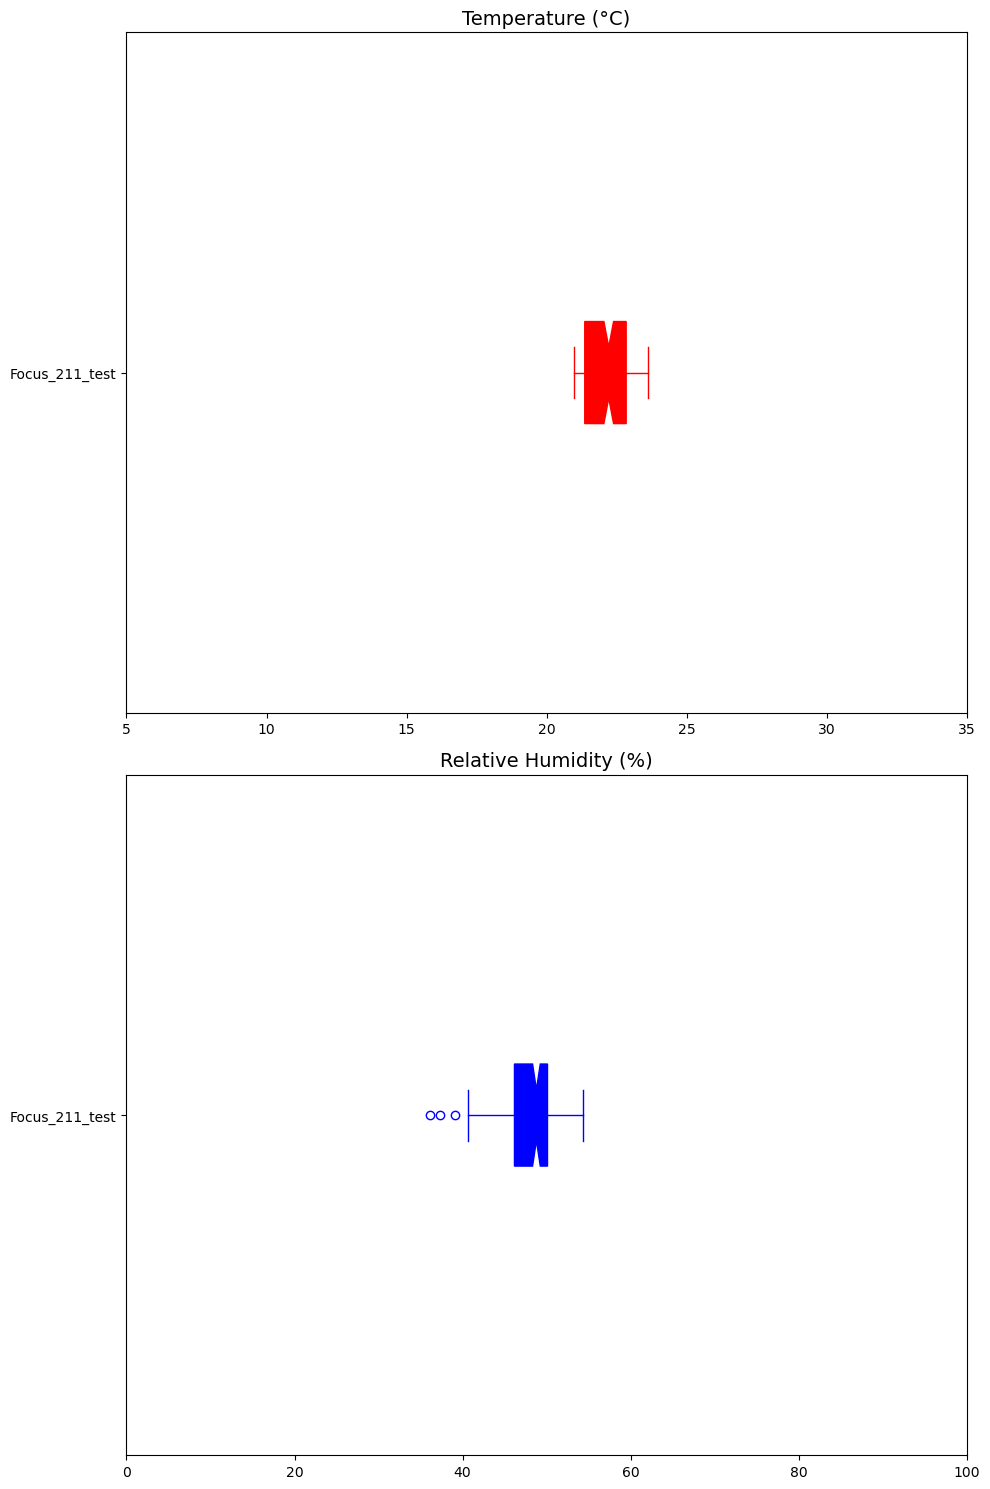

In [118]:

f3, ax = plt.subplots(2,1,figsize=(10,15),sharex=False)
print (names)

# Temperature (°C)

data_temp = []
data_temp = pd.DataFrame(data_temp)

i = 0
for name in names:
    data_temp[name] = dfs[i].set_index('DateTime').resample(num_samp).mean().reset_index().Temp
    i = i + 1

data_temp = data_temp.to_numpy()

ax[0].axes.get_xaxis().set_visible(True)
ax[0].axes.get_yaxis().set_visible(True) 
c = "red"
ax[0].boxplot(data_temp, patch_artist = True,
                notch ='True', vert = 0,
                boxprops=dict(facecolor=c, color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c))
ax[0].set_yticklabels(names)
ax[0].set_title("Temperature (°C)", size = 14)
ax[0].set_xlim([5,35])


# Relative Humidity (%)

data_rh = []
data_rh = pd.DataFrame(data_rh)

i = 0
for name in names:
    data_rh[name] = dfs[i].set_index('DateTime').resample(num_samp).mean().reset_index().RH
    i = i + 1

data_rh = data_rh.to_numpy()

ax[1].axes.get_xaxis().set_visible(True) #set X axis 
ax[1].axes.get_yaxis().set_visible(True) #set Y axis
c = "blue"
ax[1].boxplot(data_rh, patch_artist = True,
                notch ='True', vert = False,
                boxprops=dict(facecolor=c, color=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c))
ax[1].set_yticklabels(names)
ax[1].set_title("Relative Humidity (%)", size = 14)
ax[1].set_xlim([0,100])

f3.tight_layout()
plt.show()

### 7. Psychrometric chart

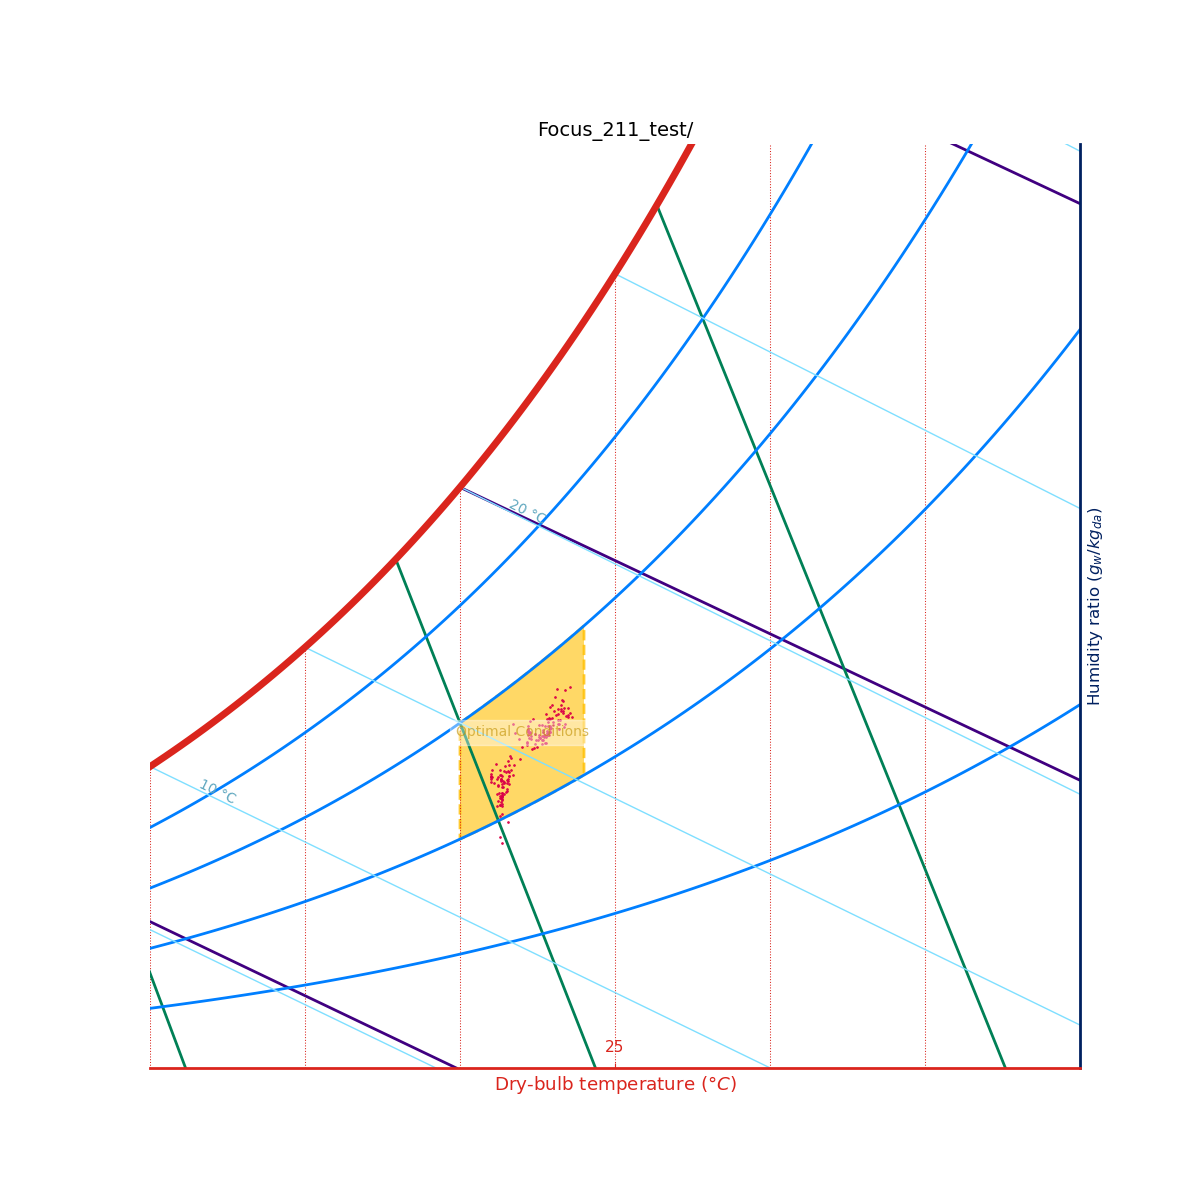

In [119]:
%matplotlib inline
%matplotlib widget
from psychrochart import PsychroChart, load_config

chart = PsychroChart('minimal')

# Target zones:
zones_conf = {
    "zones":[{
            "zone_type": "dbt-rh",
            "style": {"edgecolor": [1.0, 0.749, 0.0, 0.8],
                      "facecolor": [1.0, 0.749, 0.0, 0.6],
                      "linewidth": 2,
                      "linestyle": "--"},
            "points_x": [20, 24],
            "points_y": [40, 60],
            "label": "Optimal Conditions"
        }]}
chart.append_zones(zones_conf)
f4, ax = plt.subplots(figsize=(12, 12))
chart.plot(ax)

# Change sensor numbers according to location you'd like to analyse
sensor = 0


points = {'0': {'label': names[sensor],
                       # RGB values and transparency (closer to 0, more transparent)
                       'style': {'color': [0.855, 0.004, 0.278, 0.8],
                                 'marker': 'X', 'markersize': 1},
                       'xy': (data_temp[0, sensor], data_rh[0, sensor])}
          }
for i in range(1,len(data_temp[:,sensor])):
    points[str(i)] = {'label': names[sensor],
                       'style': {'color': [0.855, 0.004, 0.278, 0.8],
                                 'marker': 'X', 'markersize': 1},
                       'xy': (data_temp[i, sensor], data_rh[i, sensor])}
    

chart.plot_points_dbt_rh(points)

#ax.get_figure()
ax.set_title(names[sensor] + "/" , size = 14)
plt.show()

### 8-1. Heat map: Relative Humidity (%)

[[0. 0. 0. 0. 0. 0.]]


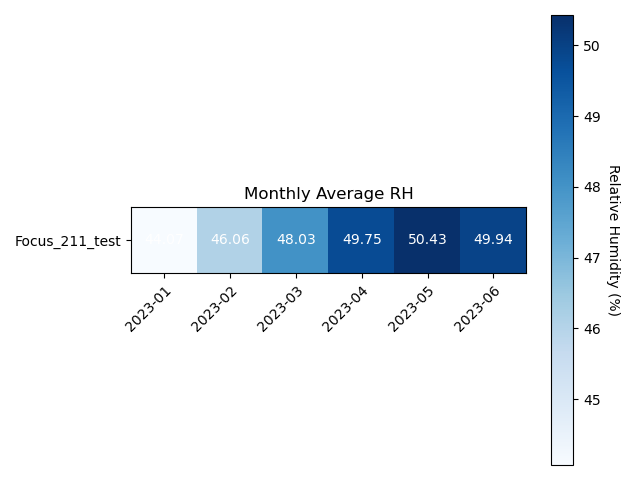

In [155]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt


# dfs[0] = the first sensor
AvRH = dfs[0].set_index('DateTime').resample('1M').mean().reset_index().RH 
Avdate = dfs[0].set_index('DateTime').resample('1M').mean().reset_index().DateTime.dt.strftime('%Y-%m')

np_arr = np.zeros((len(names), len(Avdate)))

print(np_arr)
np_arr[0,] = AvRH

#loop
if len(names) > 1:
    for i in range(1,len(names)):
        AvRH = dfs[i].set_index('DateTime').resample('1M').mean().reset_index().RH
        np_arr[i,] = AvRH
        
np_arr = np_arr.round(2) #decimal points
fig, ax = plt.subplots()

# im = heat map
im = ax.imshow(np_arr, cmap = 'Blues')

ax.set_xticks(np.arange(len(Avdate)), labels=Avdate)
ax.set_yticks(np.arange(len(names)), labels=names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(names)):
    for j in range(len(Avdate)):
        text = ax.text(j, i, np_arr[i, j],
                       ha="center", va="center", color="w")
        
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Relative Humidity (%)', rotation=-90, va="bottom")
#cbar.ax.set_ylim([40,60])

ax.set_title("Monthly Average RH")
fig.tight_layout()
plt.show()



### 8-2. Heat map: Temperature ()

[[0. 0. 0. 0. 0. 0.]]


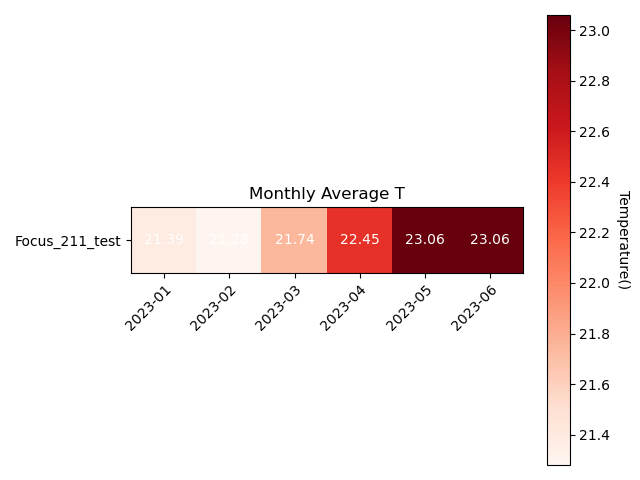

In [154]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt


# dfs[0] = the first sensor
AvT = dfs[0].set_index('DateTime').resample('1M').mean().reset_index().Temp 
Avdate = dfs[0].set_index('DateTime').resample('1M').mean().reset_index().DateTime.dt.strftime('%Y-%m')

np_arr = np.zeros((len(names), len(Avdate)))

print(np_arr)
np_arr[0,] = AvT

#loop
if len(names) > 1:
    for i in range(1,len(names)):
        AvRH = dfs[i].set_index('DateTime').resample('1M').mean().reset_index().Temp
        np_arr[i,] = AvT
        
np_arr = np_arr.round(2) #decimal points
fig, ax = plt.subplots()

# im = heat map
im = ax.imshow(np_arr, cmap = 'Reds')

ax.set_xticks(np.arange(len(Avdate)), labels=Avdate)
ax.set_yticks(np.arange(len(names)), labels=names)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(names)):
    for j in range(len(Avdate)):
        text = ax.text(j, i, np_arr[i, j],
                       ha="center", va="center", color="w")
        
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Temperature()', rotation=-90, va="bottom")
#cbar.ax.set_ylim([18,25])

ax.set_title("Monthly Average T")
fig.tight_layout()
plt.show()